# Social Media Analytics
Twitter data can be useful in a number of different ways for journalism, such as helping to identify events, to understand the aggregate flows and trends of information, or to locate key sources within the network. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Makes it so that you can scroll horizontally to see all columns of an output DataFrame
pd.set_option('display.max_columns', None)
# Make it so urls and tweets won't get truncated when we print them out
pd.set_option('display.max_colwidth', -1)

# This magic function allows you to see the charts directly within the notebook. 
%matplotlib inline

# This command will make the plots more attractive by adopting the commone style of ggplot
matplotlib.style.use("ggplot")

### Gamergate
Andy Baio collected thousands of tweets over a period of 72 hours which used the #Gamergate hashtag. His analysis is [here](https://medium.com/message/72-hours-of-gamergate-e00513f7cf5d#.c12plmtcf) but below we'll start from his raw data and do some of our own analysis. You can download the data [here](https://www.dropbox.com/s/5zeuic9qr8v8y4n/gamergate_tweets_hydrated.csv?dl=0). 

In [2]:
gg_df = pd.read_csv("C:\Users\Deon\Downloads\gamergate_tweets_hydrated.csv")

# Print out the column headings to see what kind of data we have
gg_df.columns

Index([u'long', u'lat', u'created_at', u'hashtags', u'media', u'urls',
       u'favorite_count', u'id', u'in_reply_to_screen_name',
       u'is_quote_status', u'in_reply_to_status_id', u'in_reply_to_user_id',
       u'lang', u'place', u'state', u'country', u'possibly_sensitive',
       u'retweet_count', u'reweet_id', u'retweet_screen_name', u'source',
       u'text', u'tweet_url', u'user_created_at', u'user_screen_name',
       u'user_default_profile_image', u'user_description',
       u'user_favourites_count', u'user_followers_count',
       u'user_friends_count', u'user_listed_count', u'user_location',
       u'user_name', u'user_statuses_count', u'user_time_zone', u'user_urls',
       u'user_verified', u'user_lang'],
      dtype='object')

### Analyzing Conversation

In [3]:
# Number of tweets sent
print gg_df.shape[0]

#Number of Unique screen names that sent tweets
gg_df["user_screen_name"].unique().shape[0]

215153


33080L

**The number of original tweets vs. retweets can indicate how much new information is being created in comparison to information that is being passed along;**

To calculate the number of original tweets versus retweets are in the data we can do some counting:

In [5]:
# Number of Original Tweets
# if reweet_id is null then it's original, otherwise the tweet is a retweet of the given retweet_id
print "Num Retweets:", gg_df["reweet_id"].count()
retweets = gg_df["reweet_id"].count()
print "Num Original Tweets:", gg_df.shape[0] - retweets



Num Retweets: 135829
Num Original Tweets: 79324


**The number of tweets that are replies directly to another users can be a measure of how "chatty" the event is;**


In [6]:
# Number of Reply Tweets
# in_reply_to_status_id is not null if the tweet is a reply to another tweet. 
print "Num Replies: %d, which is %.2f%% of total." %  (gg_df["in_reply_to_status_id"].count(), float(gg_df["in_reply_to_status_id"].count()) / gg_df.shape[0]*100) 


Num Replies: 29423, which is 13.68% of total.


In [7]:
gg_user = gg_df.groupby('user_screen_name')
print "Top 10 Users by # Tweets"
top10_users = gg_user.size().sort_values(ascending=False)[0:10]
top10_users

Top 10 Users by # Tweets


user_screen_name
SomeKindaBoogin    1974
KotakuInAction     1171
WishiwasArcher     923 
dav_thwomp         751 
Queldan_WoW        731 
MSamenfink         714 
LapewtanMachine    710 
Blaugast           666 
Twodeadclerks      646 
EscapeVelo         640 
dtype: int64

**Most active users on twitter in the DF and respective demographics**

In [8]:
gg_top10_users = gg_df[gg_df["user_screen_name"].isin(top10_users.index.values)]
print "%d tweets from top 10 users \n" % gg_top10_users.shape[0]
top10_grouped = gg_top10_users.groupby("user_screen_name")
top10_grouped['retweet_count'].mean()



8926 tweets from top 10 users 



user_screen_name
Blaugast           10.977477
EscapeVelo         7.137500 
KotakuInAction     0.253629 
LapewtanMachine    40.267606
MSamenfink         8.044818 
Queldan_WoW        48.035568
SomeKindaBoogin    16.539514
Twodeadclerks      16.973684
WishiwasArcher     49.461538
dav_thwomp         19.707057
Name: retweet_count, dtype: float64

**Sensive data and propogation on social media**

In [9]:

sensitive = gg_df[gg_df.possibly_sensitive == True]
print sensitive["retweet_count"].median() #gives the median and mean amount of retweets for data that can be considered sensitive
print sensitive["retweet_count"].mean()

28.0
111.605734767


In [88]:
gg_df.columns

Index([u'long', u'lat', u'created_at', u'hashtags', u'media', u'urls',
       u'favorite_count', u'id', u'in_reply_to_screen_name',
       u'is_quote_status', u'in_reply_to_status_id', u'in_reply_to_user_id',
       u'lang', u'place', u'state', u'country', u'possibly_sensitive',
       u'retweet_count', u'reweet_id', u'retweet_screen_name', u'source',
       u'text', u'tweet_url', u'user_created_at', u'user_screen_name',
       u'user_default_profile_image', u'user_description',
       u'user_favourites_count', u'user_followers_count',
       u'user_friends_count', u'user_listed_count', u'user_location',
       u'user_name', u'user_statuses_count', u'user_time_zone', u'user_urls',
       u'user_verified', u'user_lang'],
      dtype='object')

### The Pulse of the Event
What's the shape of the event in terms of the hashtags that are used? 

Let's first examine the set of hashtags that are used at all:

In [10]:
# The hashtags field can have multiple hashtags stuffed into it, separated by a space so we need to parse those out separately to be able to count them
hashtags_list = []

def parse_hashtags(hashtags):
    
    hashtags_list.extend(hashtags.split(" "))
    
gg_df["hashtags"].dropna().map(parse_hashtags)

hashtags_df = pd.DataFrame(hashtags_list, columns=["hashtag"])
hashtags_df["hashtag"] = hashtags_df["hashtag"].map(lambda x: x.lower())
print "Number of unique hashtags: %d " % hashtags_df["hashtag"].unique().shape[0]
print "\nTop Ten Hashtags:"
print hashtags_df["hashtag"].value_counts()[0:10]

print ""
top_ten_hashtags = hashtags_df["hashtag"].value_counts()[0:10].index.values
print top_ten_hashtags

Number of unique hashtags: 3506 

Top Ten Hashtags:
gamergate            216125
notyourshield        21251 
fullmcintosh         2704  
stopgamergate2014    2264  
gamejournopros       939   
notyourscapegoat     846   
iloveadobe           727   
gamerfruit           546   
videogames           382   
notfeminism          336   
Name: hashtag, dtype: int64

['gamergate' 'notyourshield' 'fullmcintosh' 'stopgamergate2014'
 'gamejournopros' 'notyourscapegoat' 'iloveadobe' 'gamerfruit' 'videogames'
 'notfeminism']


Now let's plot these hashtags over time so we can see the shape of how they were used and if there are any patterns. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013BA99B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001541A828>]], dtype=object)

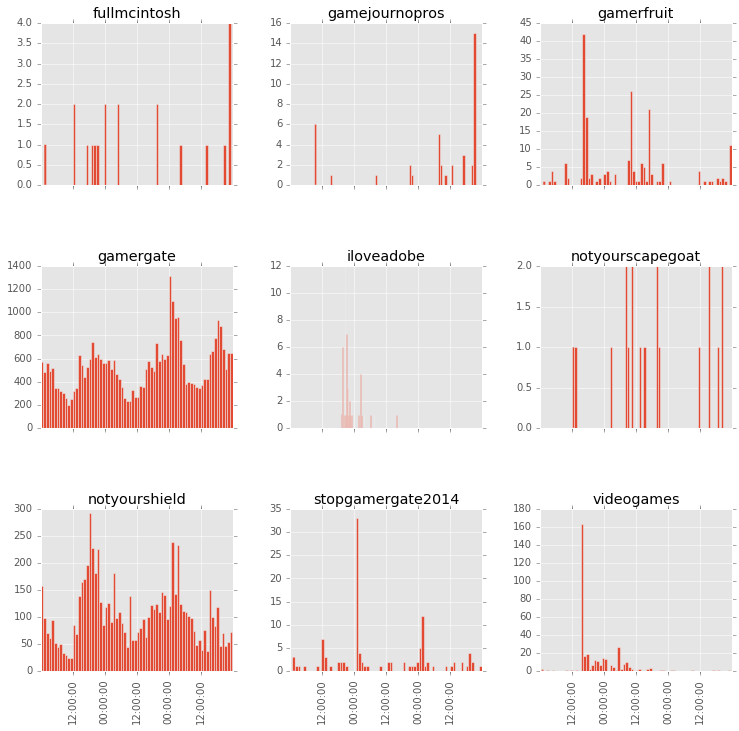

In [11]:
# We need both the hashtags and the creation date in the same list to plot one against the other
# Here just tabulate for the top 10 hashtags
hashtags_list = []

def parse_hashtags(row):
    #print hashtags
    htags = row["hashtags"].split(" ")
    for h in htags:
        if h in top_ten_hashtags:
            hashtags_list.append([h.lower(), row["created_at"]])
    
gg_df.dropna(subset=["hashtags"]).apply(parse_hashtags, axis=1)

# Create a data frame from the list
hashtags_df = pd.DataFrame(hashtags_list, columns=["hashtag", "created_at"])
# Need to parse the created_at field as a datetime
hashtags_df["created_at"] = pd.DatetimeIndex(hashtags_df["created_at"])
# Now generate the histogram
hashtags_df.hist(column="created_at", by="hashtag", bins=72, figsize=(12,12), sharex=True)